<a href="https://colab.research.google.com/github/Mervvick/AI_Audio_Light/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Lite_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Запустите, пожалуйста, раздел "Подготовка" и приступайте к выполнению заданий.

## Подготовка

### Импорт библиотек

In [1]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Загрузка датасета и подготовка данных

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=False)

# Загрузка подготовленных данных
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/audio_data_mean.pickle', None, quiet=True)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip
To: /content/genres.zip
100%|██████████| 1.23G/1.23G [00:51<00:00, 24.0MB/s]


'audio_data_mean.pickle'

In [3]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [4]:
# Установка констант

FILE_DIR = './genres'                     # Папка с файлами датасета
CLASS_LIST = os.listdir(FILE_DIR)         # Список классов, порядок меток не определен!
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 90               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [5]:
# Проверка списка классов
print(CLASS_LIST)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [6]:
# Функция параметризации аудио

def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

    # Сборка параметров в общий список:
    # На один файл один усредненный вектор признаков
    features = {'rmse': rmse.mean(axis=1, keepdims=True),
                'spct': spec_cent.mean(axis=1, keepdims=True),
                'spbw': spec_bw.mean(axis=1, keepdims=True),
                'roff': rolloff.mean(axis=1, keepdims=True),
                'zcr' : zcr.mean(axis=1, keepdims=True),
                'mfcc': mfcc.mean(axis=1, keepdims=True),
                'stft': chroma_stft.mean(axis=1, keepdims=True)}

    return features

In [7]:
# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

In [8]:
# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

In [9]:
# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_index,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{class_name}/{class_name}.{str(file_index).zfill(5)}.au'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index,
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')

In [10]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=DURATION_SEC  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, file_index, duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [11]:
# Восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов

with open('/content/audio_data_mean.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)

In [12]:
# Нормирование признаков в соответствии со стандартным нормальным распределением

x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [13]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения

x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

### Функция вывода графиков точности и ошибки по эпохам обучения

In [14]:
# Вывод графиков точности и ошибки распознавания на обучающей и проверочной выборках

def show_history(history  # объект-результат метода обучения .fit()
                 ):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

### Функции визуализации распознавания отдельных звуковых файлов

In [15]:
# Классификация файла и визуализация предсказания модели для него

def classify_file(model,        # обученная модель классификатора
                  x_scaler,     # настроенный нормировщих входных данных
                  class_index,  # верный индекс класса аудиофайла
                  file_index    # индекс (порядковый номер) аудиофайла в папке
                  ):
    # Подготовка выборки данных файла произведения
    song_name, file_x_data, file_y_data = process_file(class_index, file_index, DURATION_SEC)

    # Нормирование признаков уже настроенным нормировщиком
    file_x_data = x_scaler.transform(file_x_data)

    print('Файл:', song_name)
    print('Векторы для предсказания:', file_x_data.shape)

    # Вычисление предсказания по выборке
    predict = model.predict(file_x_data)
    # Определение среднего предсказания (голосование)
    predict_mean = predict.mean(axis=0)
    # Определение индекса класса по результату голосования
    predict_class_index = np.argmax(predict_mean)
    # Вычисление признака правильного предсказания
    predict_good = predict_class_index == class_index

    # Визуализация предсказания сети для файла
    plt.figure(figsize=(10,3))
    print('Классификация сети:', CLASS_LIST[predict_class_index], '-', 'ВЕРНО :-)' if predict_good else 'НЕВЕРНО.')
    plt.title('Среднее распределение векторов предсказаний')
    plt.bar(CLASS_LIST, predict_mean, color='g' if predict_good else 'r')
    plt.show()
    print('---------------------------------------------------------------')

    # Возврат результата предсказания
    return predict_class_index

In [16]:
# Классификация и визуализация нескольких файлов каждого класса

def classify_test_files(model,       # обученная модель классификатора
                        x_scaler,    # настроенный нормировщих входных данных
                        from_index,  # индекс аудиофайла, с которого начинать визуализацию
                        n_files):    # количество файлов для визуализации
    predict_all = 0
    predict_good = 0
    y_true = []
    y_pred = []

    # Классификация каждого файла и аккумуляция результатов классификации
    for class_index in range(CLASS_COUNT):
        for file_index in range(from_index, from_index + n_files):
            predict_class_index = classify_file(model, x_scaler, class_index, file_index)
            y_true.append(class_index)
            y_pred.append(predict_class_index)
            predict_all += 1
            predict_good += (predict_class_index == class_index)

    # Расчет и вывод итогов классификации
    good_ratio = round(predict_good / predict_all * 100., 2)
    print(f'=== Обработано образцов: {predict_all}, из них распознано верно: {predict_good}, доля верных: {good_ratio}% ===')

    # Построение матрицы ошибок без нормализации, покажет попадания в штуках
    cm = confusion_matrix(y_true, y_pred)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Матрица ошибок по файлам аудио (не нормализованная)')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
    disp.plot(ax=ax)
    plt.show()

##Заданиe

В предыдущих ячейках были подготовлены все данные для обучения модели нейронной сети.
1. Проверьте форму данных обучающей и проверочной выборок (выведите на экран).

In [17]:
# Ваше решение
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(810, 37)
(810, 10)
(90, 37)
(90, 10)


2. Составьте модель классификатора на полносвязных слоях и сохраните ее в переменной **model**. Для этого:
 - Используйте заготовку для последовательной модели **Sequential**;
 - Добавьте полносвязный слой на **64** нейрона с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **30%**;
 - Добавьте следующий полносвязный слой на **32** нейрона с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **30%**;
 - Добавьте следующий полносвязный слой на **16** нейронов с активационной функцией **'relu'**, после него добавьте слой **Dropout** с долей отключаемых нейронов **20%**;
 - Добавьте слой пакетной нормализации;
 - Добавьте финальный полносвязный слой классификатора на число нейронов по числу классов (**CLASS_COUNT**) с активационной функцией **'softmax'** .

In [18]:
# Ваше решение
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = x_train.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(CLASS_COUNT, activation = 'softmax'))

3. Откомпилируйте созданную модель методом `.compile()` с указанием оптимизатора **Adam** и начальным шагом обучения **0.0001**, функцией ошибки **'categorical_crossentropy'** и метрикой **'accuracy'**;
Выведите на экран сводку архитектуры полученной модели методом `.summary()` .

In [19]:
# Ваше решение
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2432      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 batch_normalization (BatchN  (None, 16)               6

4. Обучите модель и выведите графики обучения:
 - Обучите созданную и откомпилированную модель классификатора на данных обучающей выборки **x_train, y_train**, используя проверочные данные **x_val, y_val**, размер батча **32** и количество эпох **1000**. Результаты обучения сохраните в переменной **history** .
 - В разделе **"Функция вывода графиков точности и ошибки по эпохам обучения"** найдите определение функции `show_history()`, изучите требуемые параметры для нее и используйте для построения графиков точности и ошибки на протяжении эпох обучения.

Epoch 1/1000
26/26 [==============================] - 2s 14ms/step - loss: 2.7442 - accuracy: 0.1000 - val_loss: 2.2920 - val_accuracy: 0.1333
Epoch 2/1000
26/26 [==============================] - 0s 4ms/step - loss: 2.6958 - accuracy: 0.1235 - val_loss: 2.2460 - val_accuracy: 0.2000
Epoch 3/1000
26/26 [==============================] - 0s 4ms/step - loss: 2.6314 - accuracy: 0.1062 - val_loss: 2.2097 - val_accuracy: 0.1556
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 2.6313 - accuracy: 0.1321 - val_loss: 2.1804 - val_accuracy: 0.1556
Epoch 5/1000
26/26 [==============================] - 0s 4ms/step - loss: 2.6443 - accuracy: 0.1198 - val_loss: 2.1547 - val_accuracy: 0.2000
Epoch 6/1000
26/26 [==============================] - 0s 3ms/step - loss: 2.5984 - accuracy: 0.1210 - val_loss: 2.1311 - val_accuracy: 0.1889
Epoch 7/1000
26/26 [==============================] - 0s 3ms/step - loss: 2.4961 - accuracy: 0.1642 - val_loss: 2.1106 - val_accuracy: 0.2000
Epoch

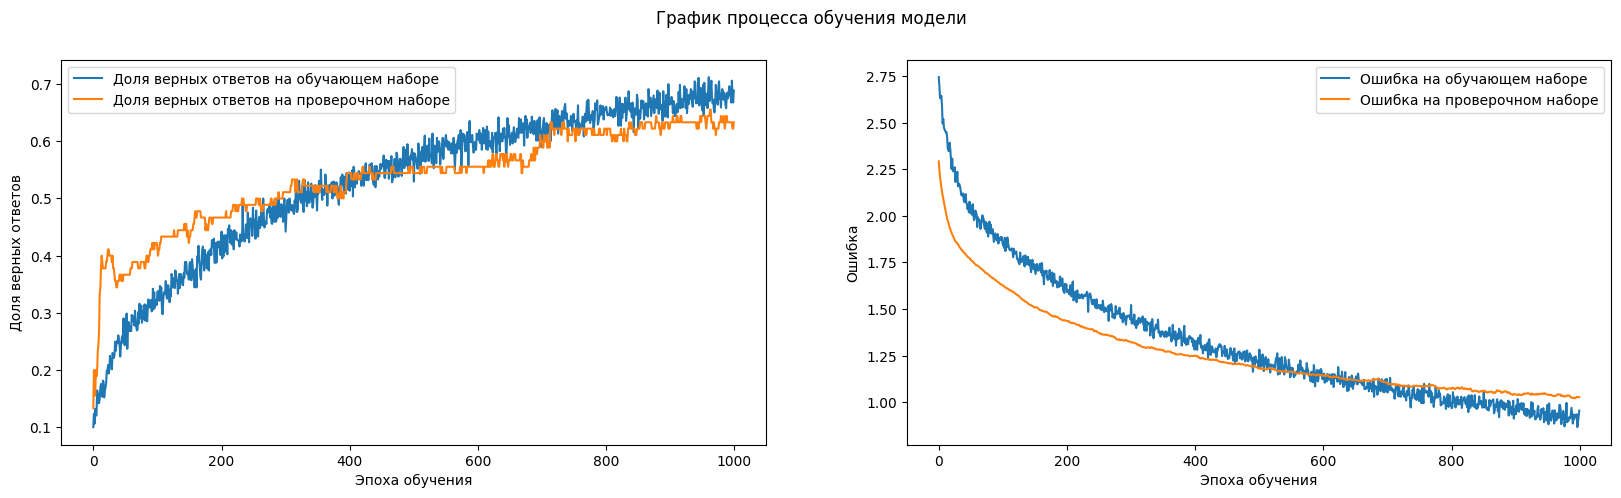

In [20]:
# Ваше решение
history = model.fit(x_train,
                    y_train,
                    batch_size = 32,
                    epochs = 1000,
                    verbose = 1,
                    validation_data = (x_val, y_val)
                    )
show_history(history)

5. Проверьте работу модели:
 - В разделе **Функции визуализации распознавания отдельных звуковых файлов** найдите определение функции `classify_test_files()` и изучите ее параметры. Используйте функцию для визуализации работы классификатора на произвольном количестве тестовых звуковых файлов, полагая, что:
 - вы используете обученная в задании 4 модель классификатора аудио;
 - нормализатор **x_scaler** уже настроен ранее в ноутбуке, и его нужно передать в функцию `classify_test_files()` вместо параметра **x_scaler**;
 - тестовые звуковые файлы начинаются с индекса **90** и всего их ровно **10** для каждого класса.

Файл: ./genres/blues/blues.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 191ms/step
Классификация сети: disco - НЕВЕРНО.


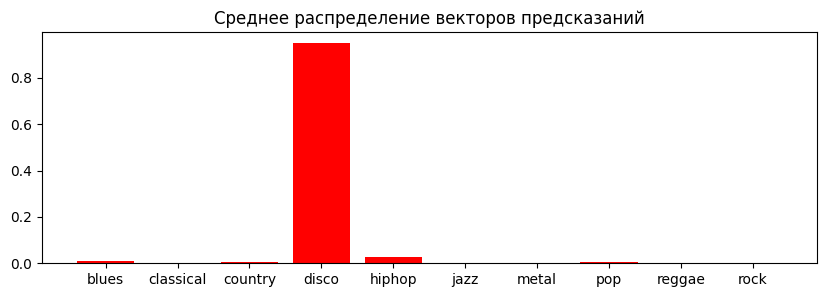

---------------------------------------------------------------
Файл: ./genres/blues/blues.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: country - НЕВЕРНО.


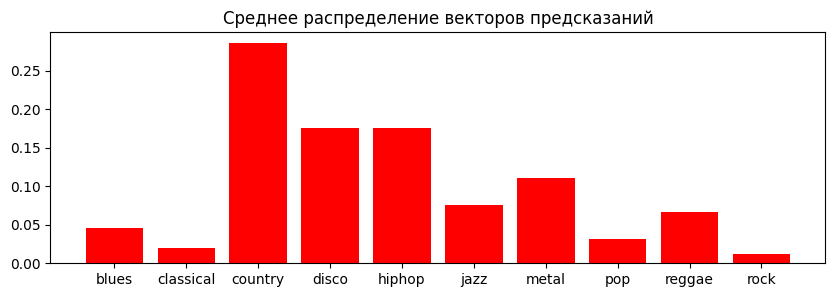

---------------------------------------------------------------
Файл: ./genres/blues/blues.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


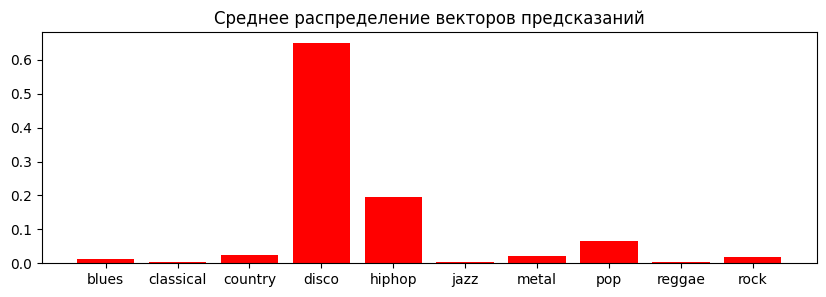

---------------------------------------------------------------
Файл: ./genres/blues/blues.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


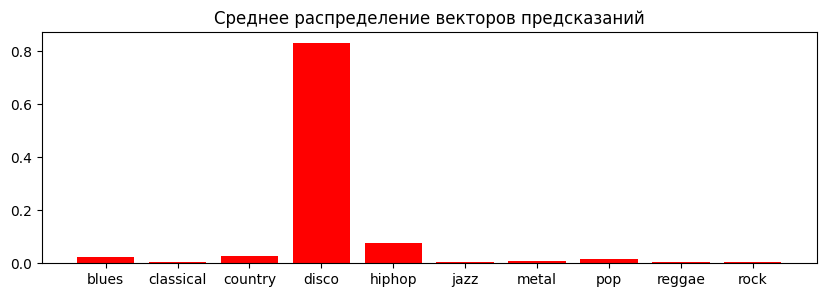

---------------------------------------------------------------
Файл: ./genres/blues/blues.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: hiphop - НЕВЕРНО.


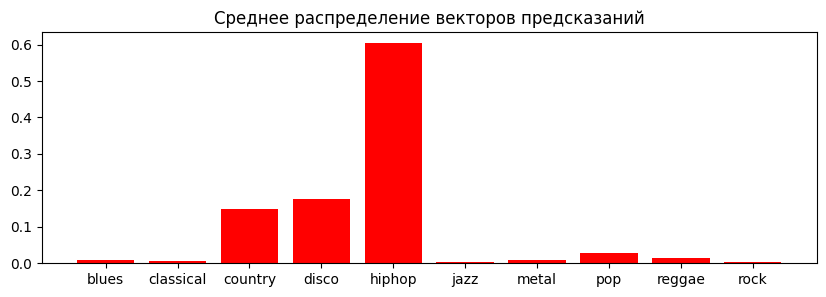

---------------------------------------------------------------
Файл: ./genres/blues/blues.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


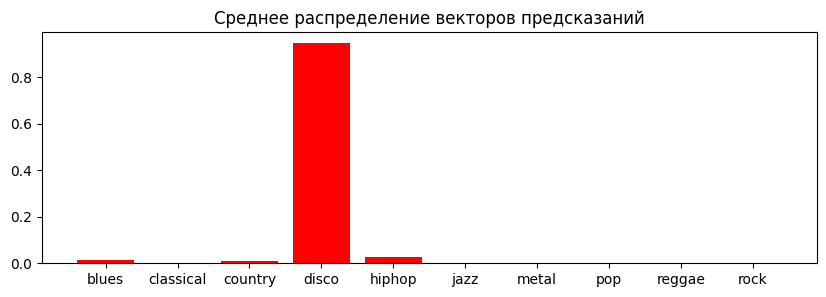

---------------------------------------------------------------
Файл: ./genres/blues/blues.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: hiphop - НЕВЕРНО.


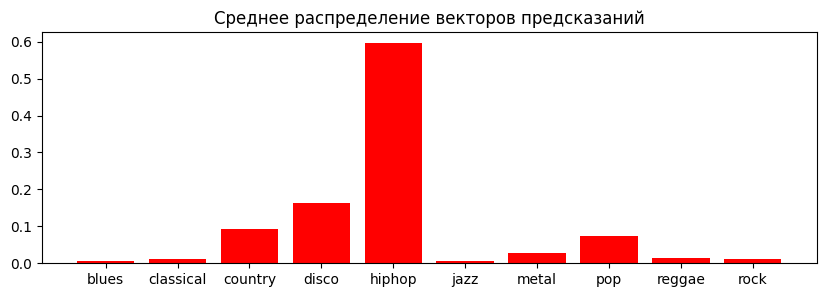

---------------------------------------------------------------
Файл: ./genres/blues/blues.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 28ms/step
Классификация сети: disco - НЕВЕРНО.


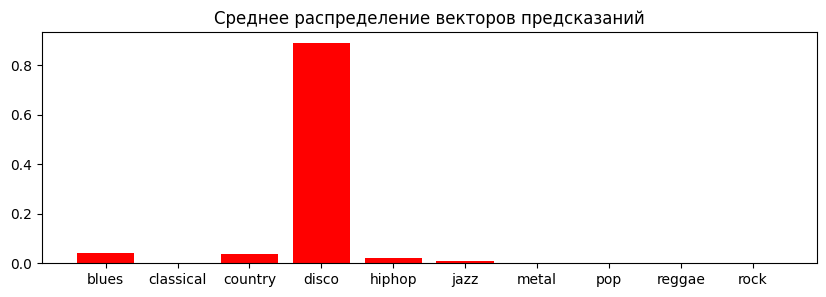

---------------------------------------------------------------
Файл: ./genres/blues/blues.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: blues - ВЕРНО :-)


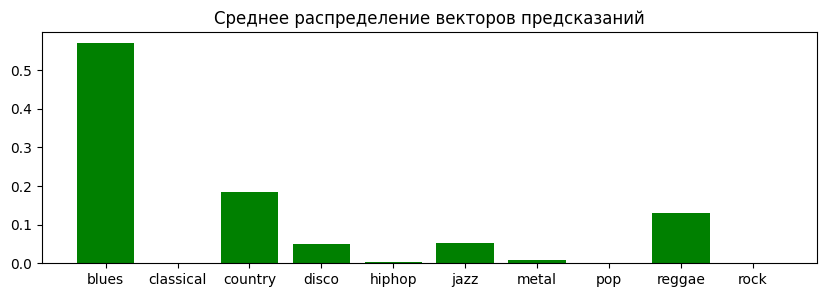

---------------------------------------------------------------
Файл: ./genres/blues/blues.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: hiphop - НЕВЕРНО.


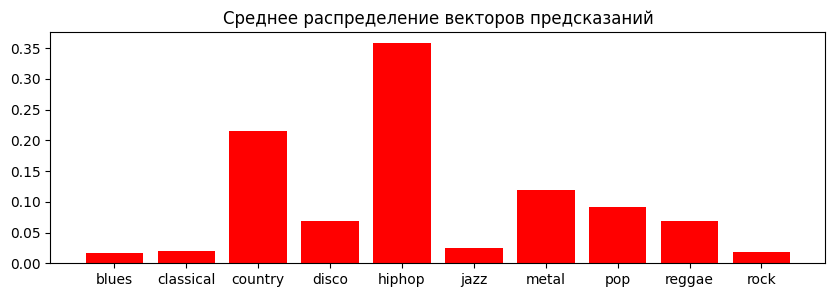

---------------------------------------------------------------
Файл: ./genres/classical/classical.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: rock - НЕВЕРНО.


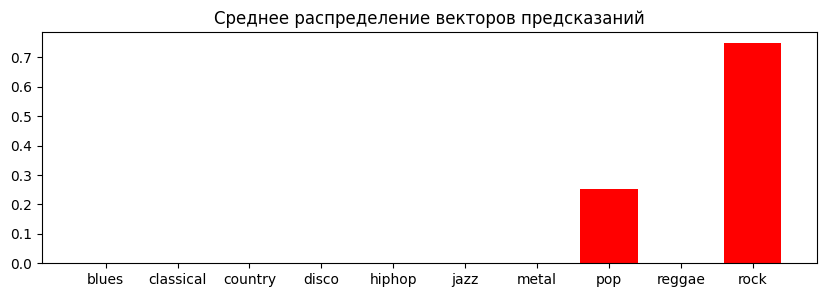

---------------------------------------------------------------
Файл: ./genres/classical/classical.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 34ms/step
Классификация сети: rock - НЕВЕРНО.


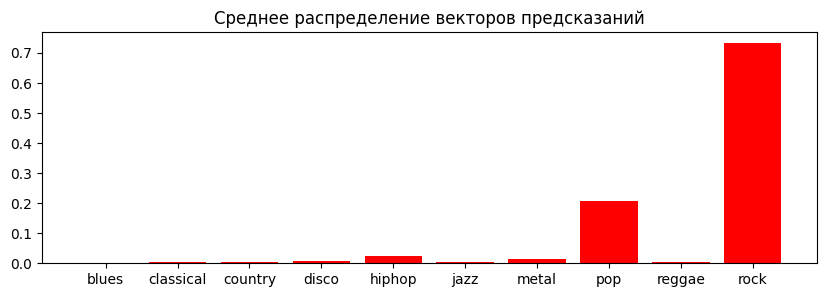

---------------------------------------------------------------
Файл: ./genres/classical/classical.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: rock - НЕВЕРНО.


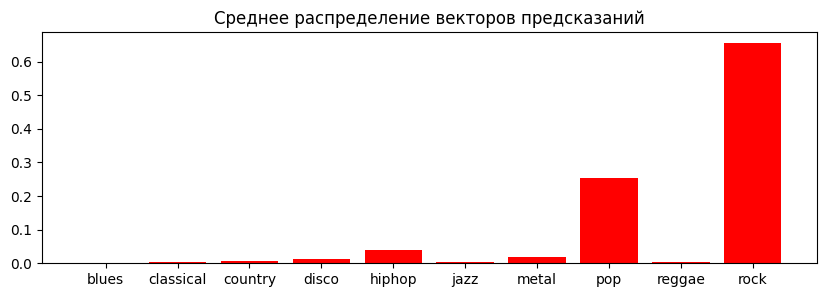

---------------------------------------------------------------
Файл: ./genres/classical/classical.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 26ms/step
Классификация сети: pop - НЕВЕРНО.


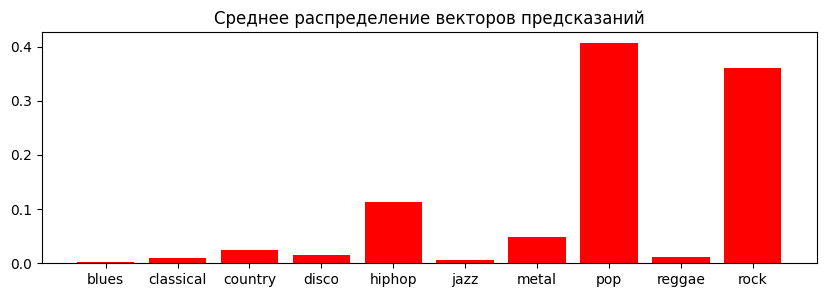

---------------------------------------------------------------
Файл: ./genres/classical/classical.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: rock - НЕВЕРНО.


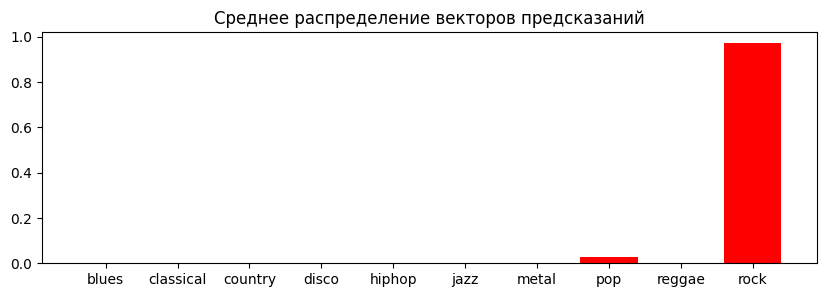

---------------------------------------------------------------
Файл: ./genres/classical/classical.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: rock - НЕВЕРНО.


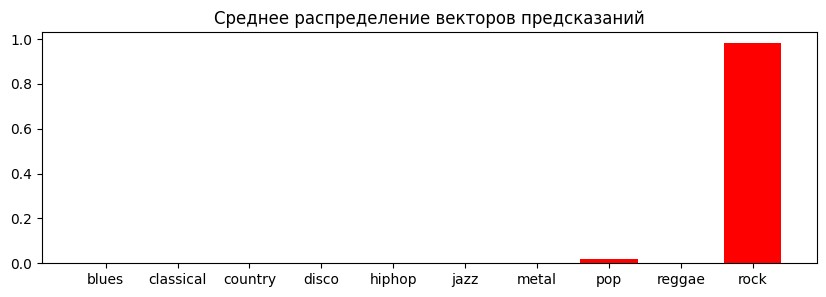

---------------------------------------------------------------
Файл: ./genres/classical/classical.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 32ms/step
Классификация сети: rock - НЕВЕРНО.


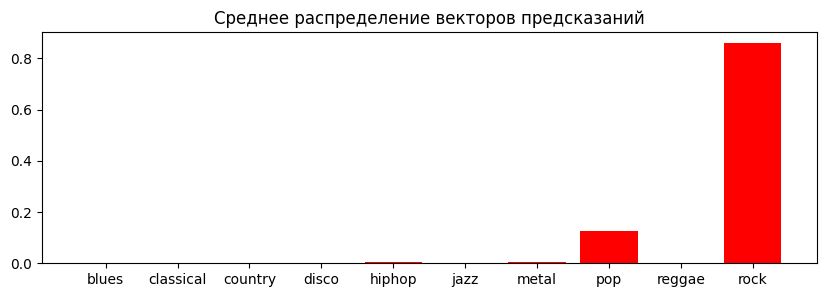

---------------------------------------------------------------
Файл: ./genres/classical/classical.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: rock - НЕВЕРНО.


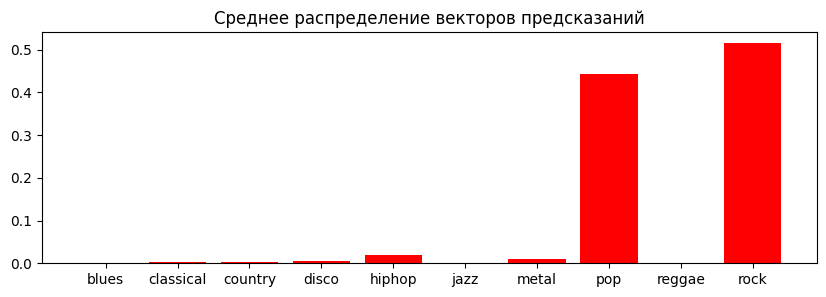

---------------------------------------------------------------
Файл: ./genres/classical/classical.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: rock - НЕВЕРНО.


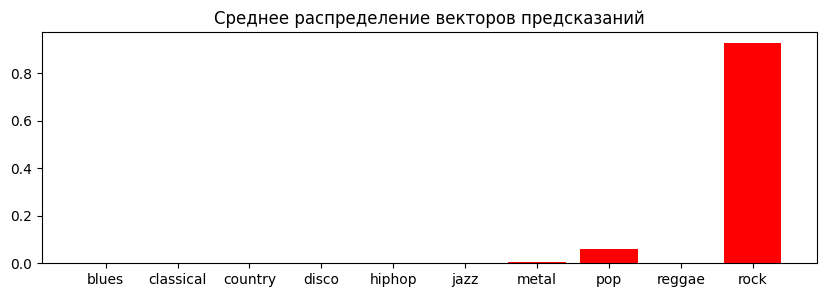

---------------------------------------------------------------
Файл: ./genres/classical/classical.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: rock - НЕВЕРНО.


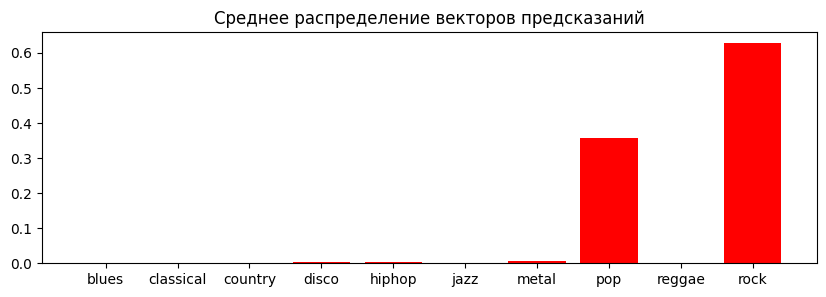

---------------------------------------------------------------
Файл: ./genres/country/country.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: disco - НЕВЕРНО.


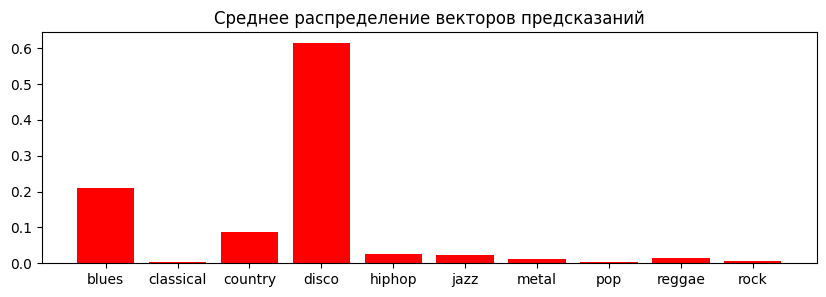

---------------------------------------------------------------
Файл: ./genres/country/country.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 32ms/step
Классификация сети: pop - НЕВЕРНО.


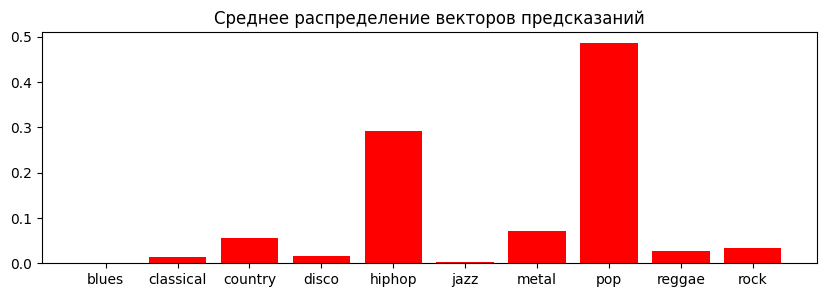

---------------------------------------------------------------
Файл: ./genres/country/country.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: country - ВЕРНО :-)


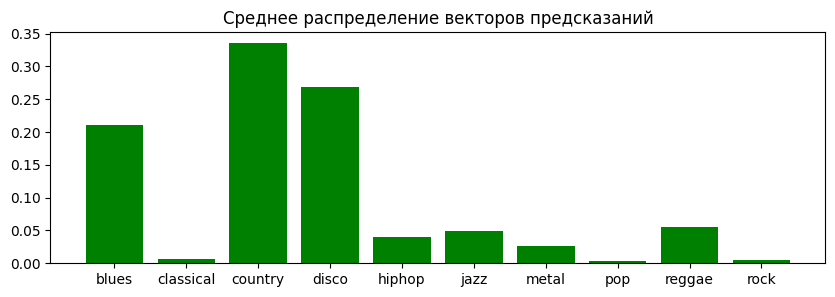

---------------------------------------------------------------
Файл: ./genres/country/country.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: hiphop - НЕВЕРНО.


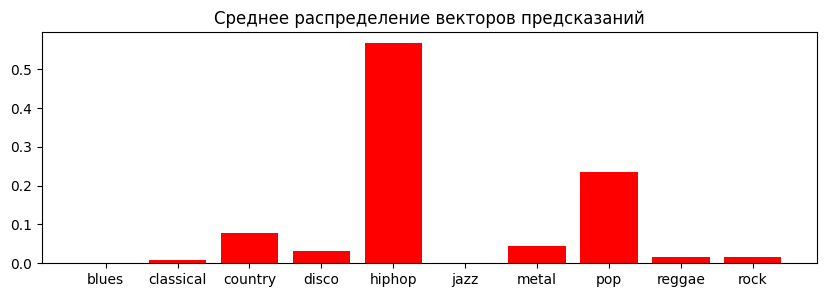

---------------------------------------------------------------
Файл: ./genres/country/country.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


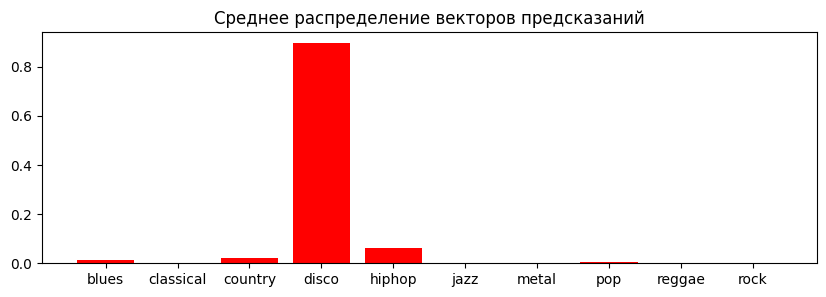

---------------------------------------------------------------
Файл: ./genres/country/country.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: disco - НЕВЕРНО.


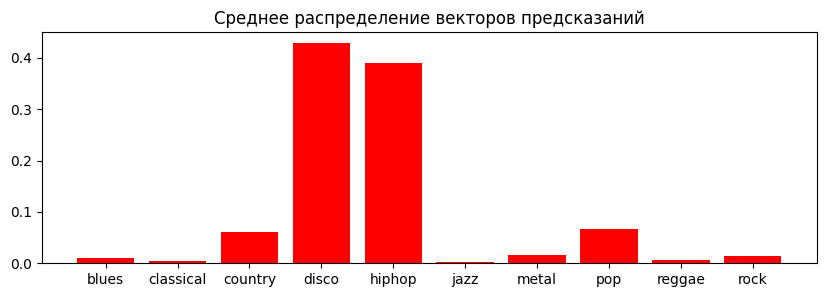

---------------------------------------------------------------
Файл: ./genres/country/country.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: hiphop - НЕВЕРНО.


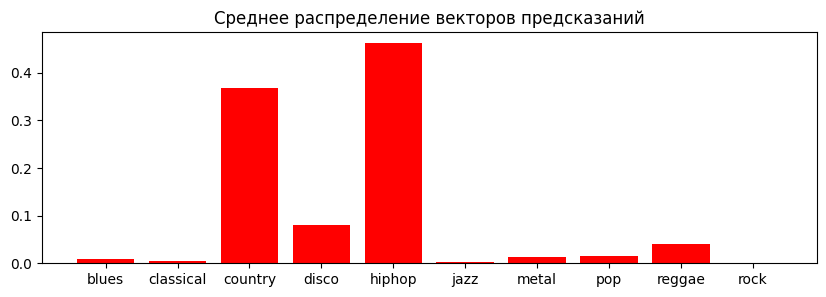

---------------------------------------------------------------
Файл: ./genres/country/country.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: hiphop - НЕВЕРНО.


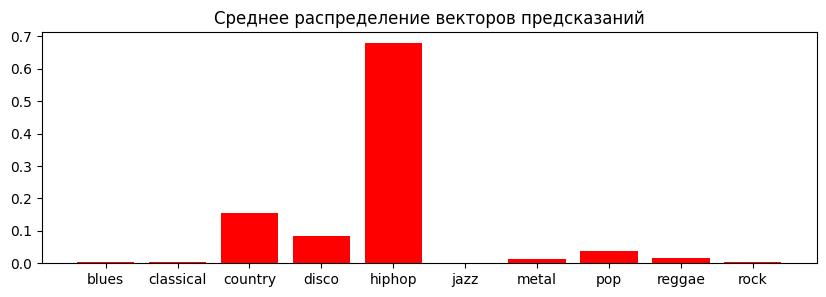

---------------------------------------------------------------
Файл: ./genres/country/country.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: disco - НЕВЕРНО.


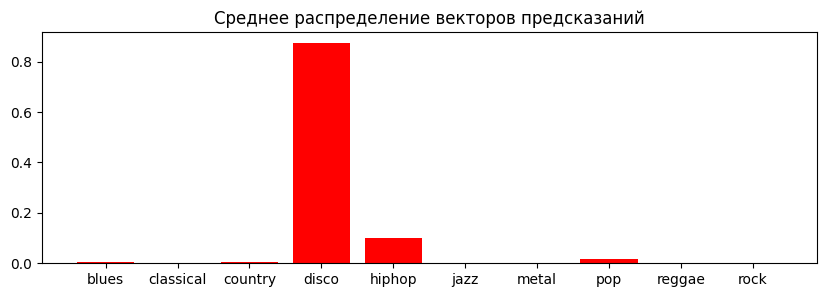

---------------------------------------------------------------
Файл: ./genres/country/country.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: disco - НЕВЕРНО.


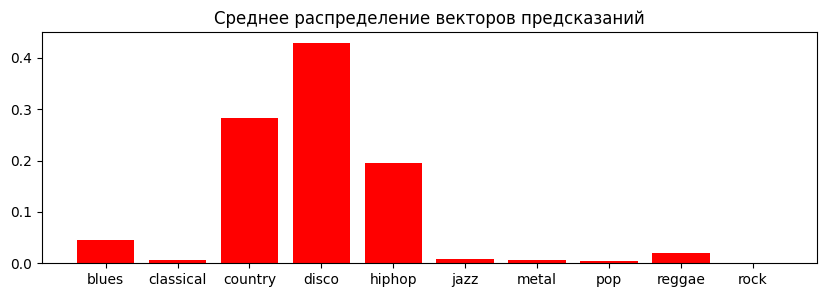

---------------------------------------------------------------
Файл: ./genres/disco/disco.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: reggae - НЕВЕРНО.


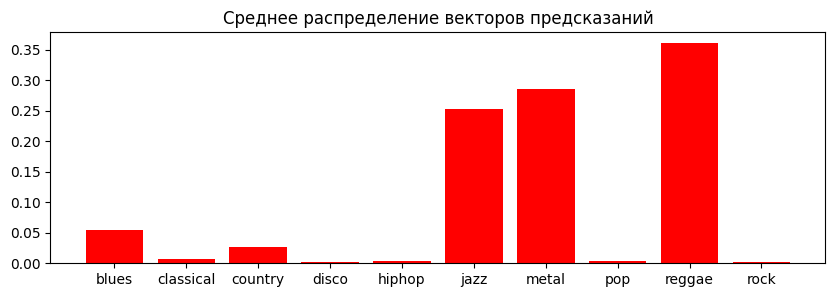

---------------------------------------------------------------
Файл: ./genres/disco/disco.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: country - НЕВЕРНО.


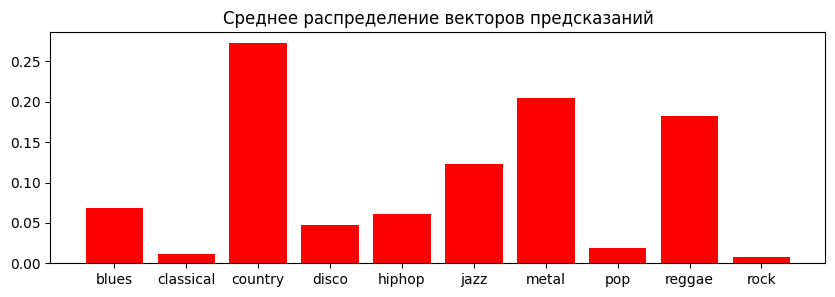

---------------------------------------------------------------
Файл: ./genres/disco/disco.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 39ms/step
Классификация сети: country - НЕВЕРНО.


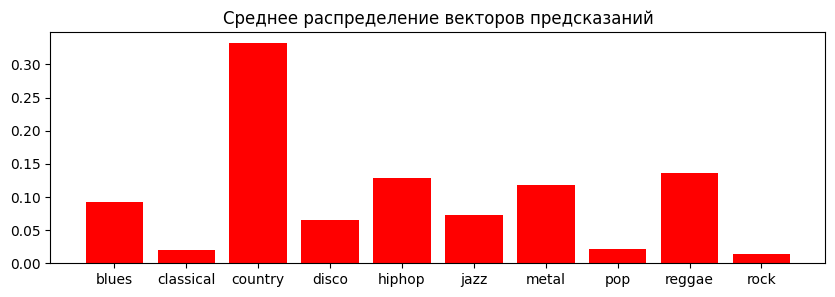

---------------------------------------------------------------
Файл: ./genres/disco/disco.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: blues - НЕВЕРНО.


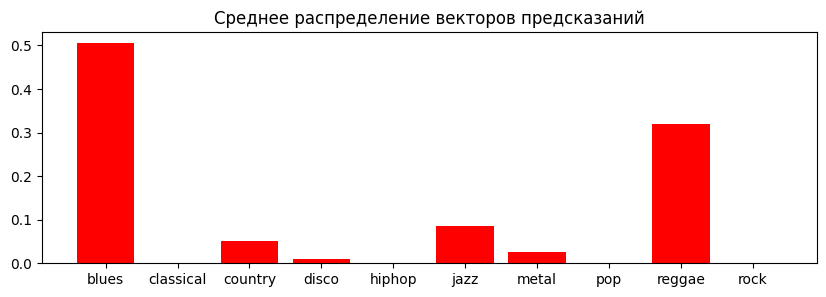

---------------------------------------------------------------
Файл: ./genres/disco/disco.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 32ms/step
Классификация сети: country - НЕВЕРНО.


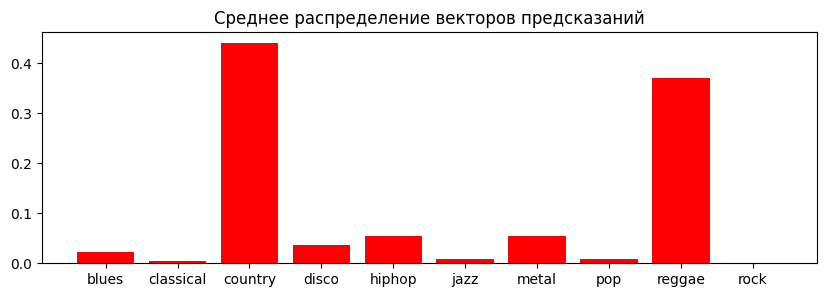

---------------------------------------------------------------
Файл: ./genres/disco/disco.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: blues - НЕВЕРНО.


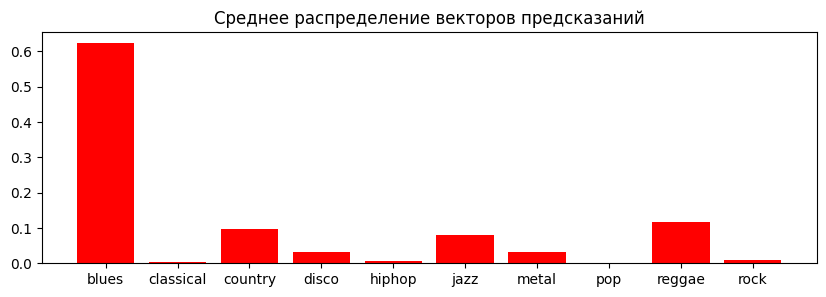

---------------------------------------------------------------
Файл: ./genres/disco/disco.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: country - НЕВЕРНО.


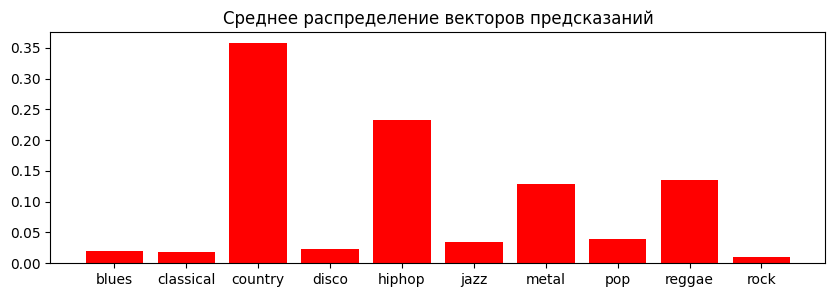

---------------------------------------------------------------
Файл: ./genres/disco/disco.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 37ms/step
Классификация сети: blues - НЕВЕРНО.


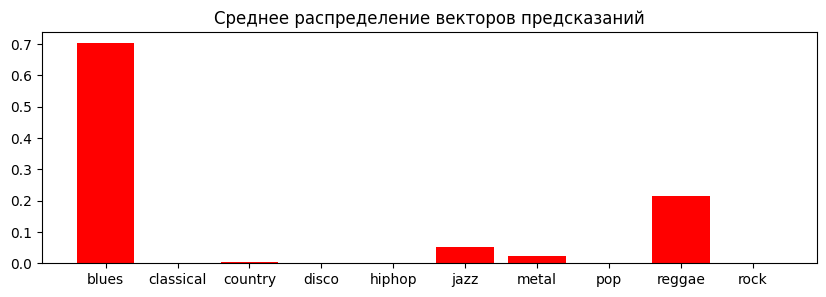

---------------------------------------------------------------
Файл: ./genres/disco/disco.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: reggae - НЕВЕРНО.


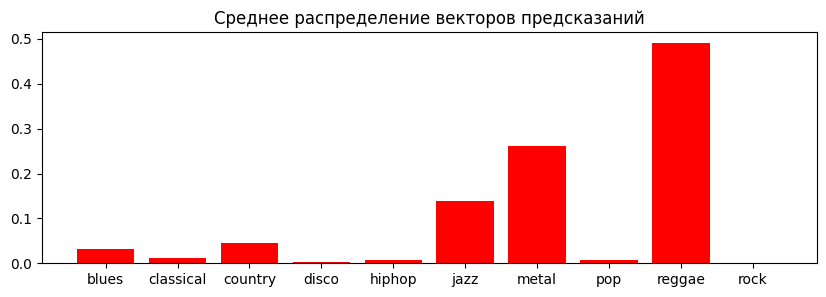

---------------------------------------------------------------
Файл: ./genres/disco/disco.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: reggae - НЕВЕРНО.


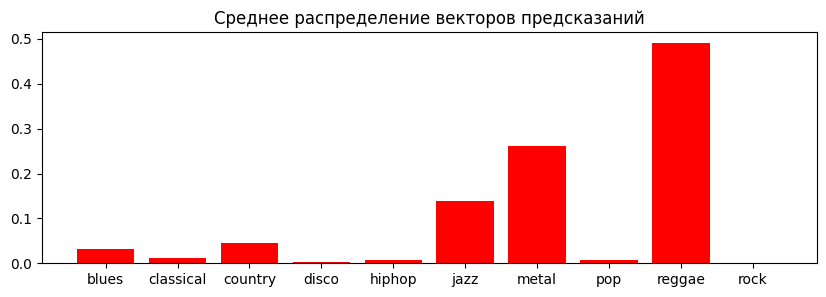

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: jazz - НЕВЕРНО.


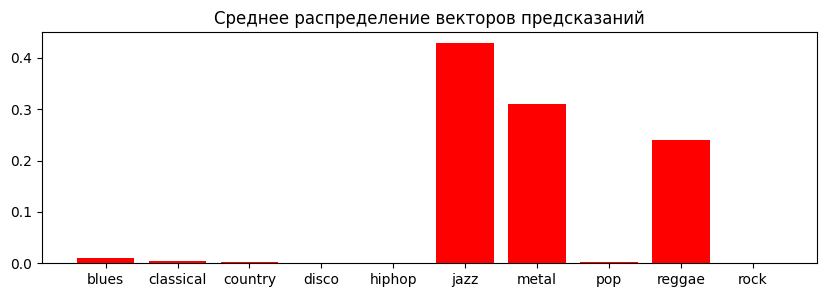

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: jazz - НЕВЕРНО.


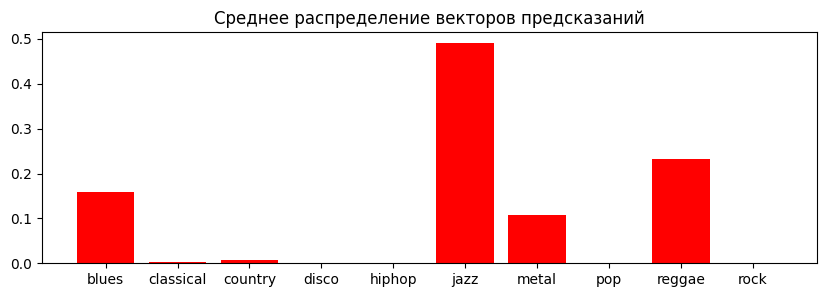

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: jazz - НЕВЕРНО.


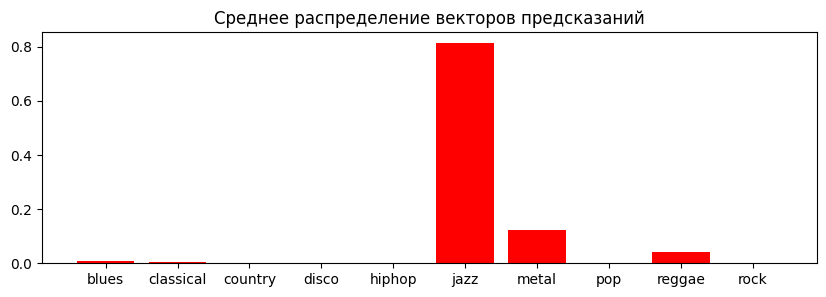

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: blues - НЕВЕРНО.


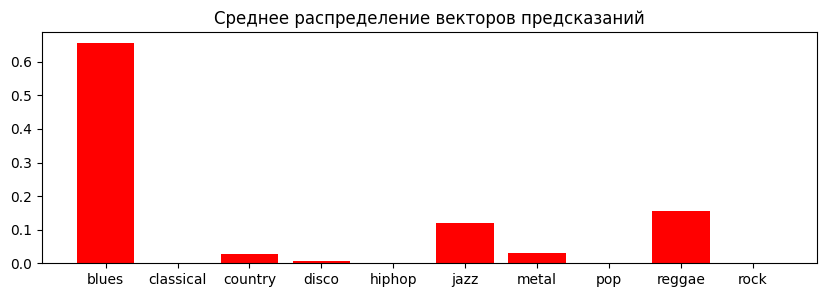

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: jazz - НЕВЕРНО.


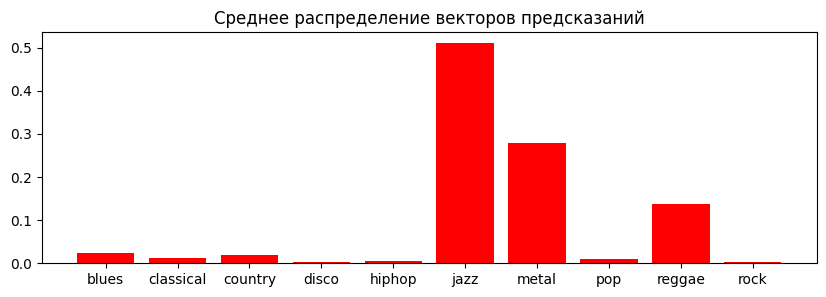

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: blues - НЕВЕРНО.


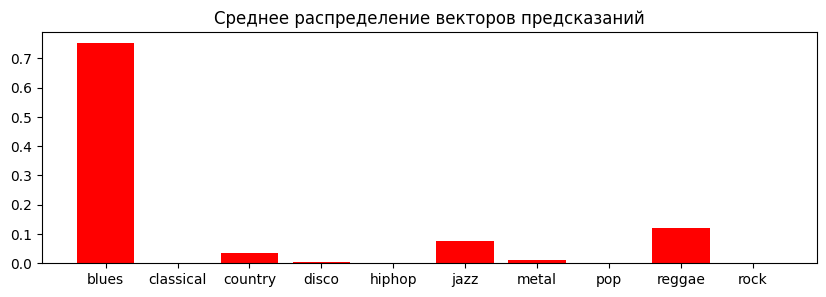

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: jazz - НЕВЕРНО.


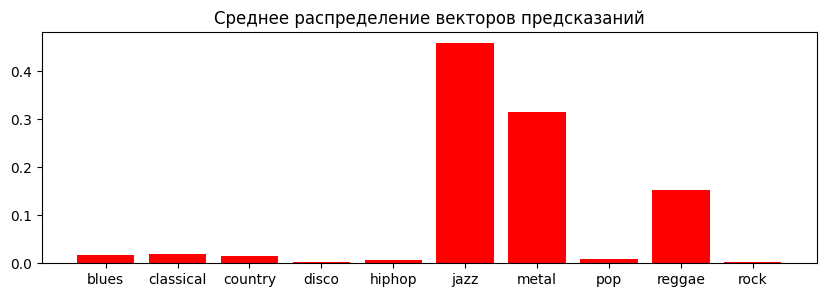

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: reggae - НЕВЕРНО.


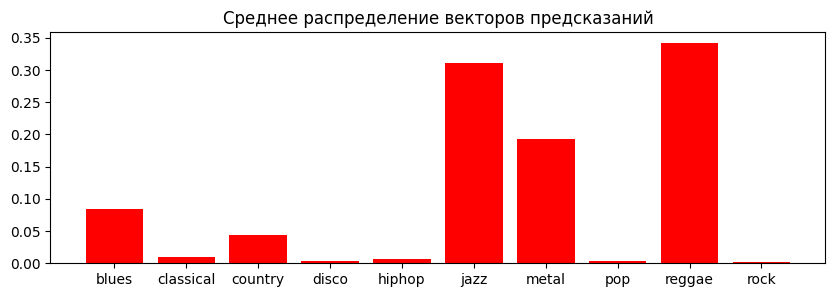

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 35ms/step
Классификация сети: jazz - НЕВЕРНО.


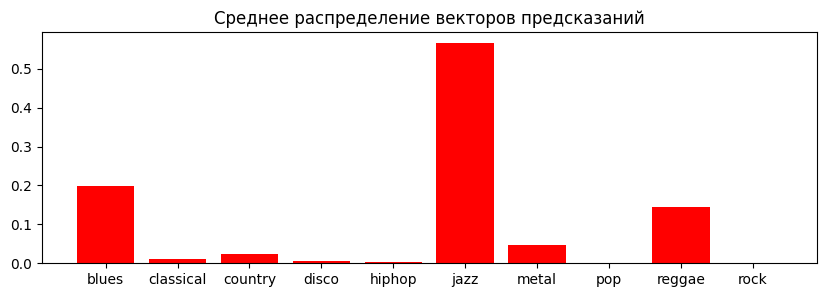

---------------------------------------------------------------
Файл: ./genres/hiphop/hiphop.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: jazz - НЕВЕРНО.


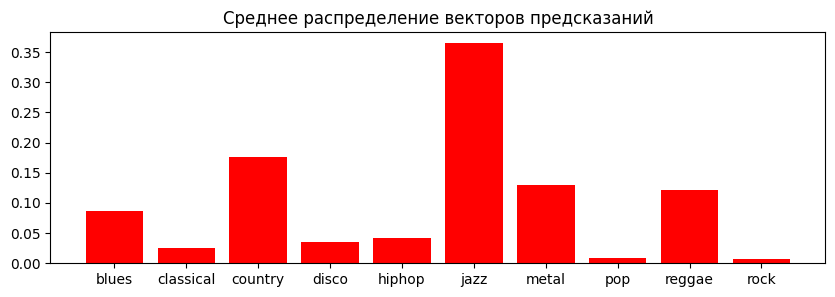

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: pop - НЕВЕРНО.


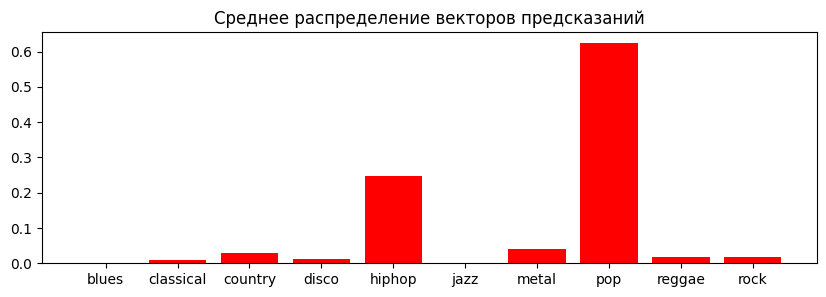

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: pop - НЕВЕРНО.


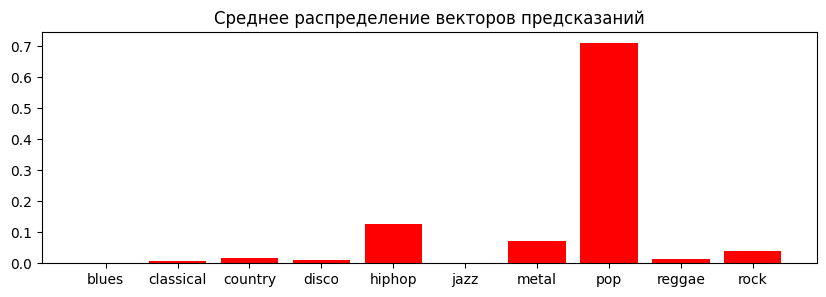

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 20ms/step
Классификация сети: pop - НЕВЕРНО.


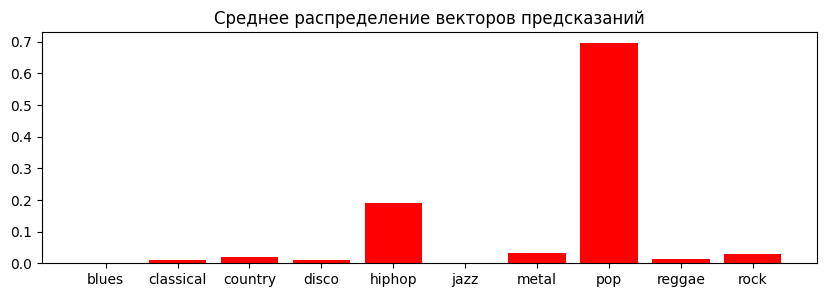

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: pop - НЕВЕРНО.


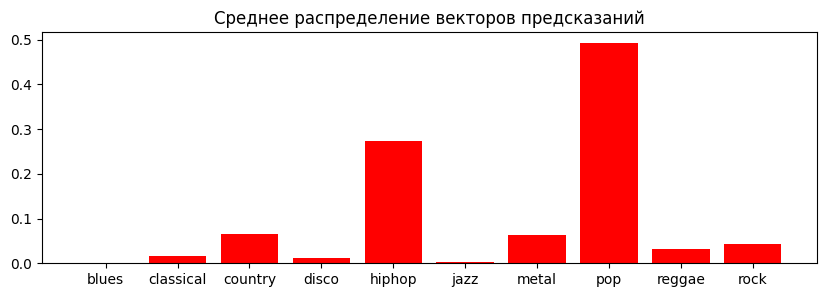

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 26ms/step
Классификация сети: pop - НЕВЕРНО.


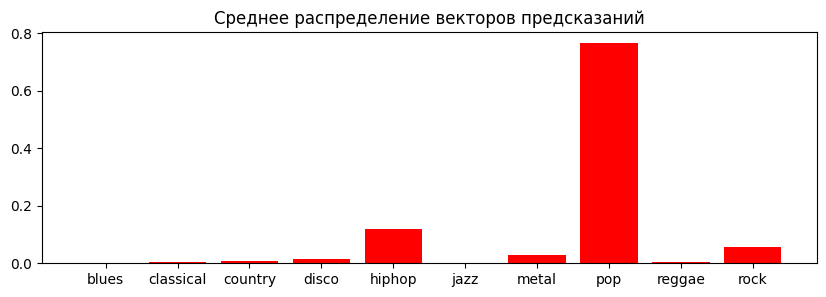

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: metal - НЕВЕРНО.


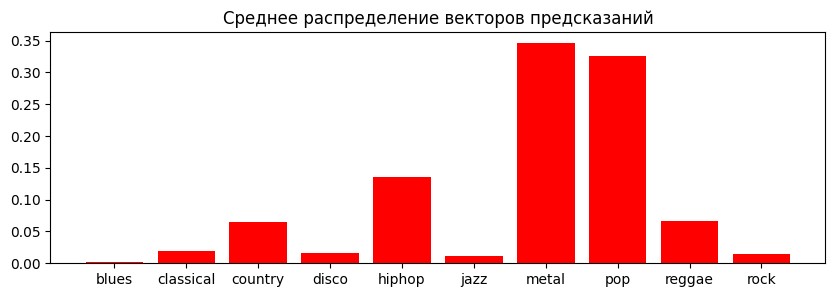

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: pop - НЕВЕРНО.


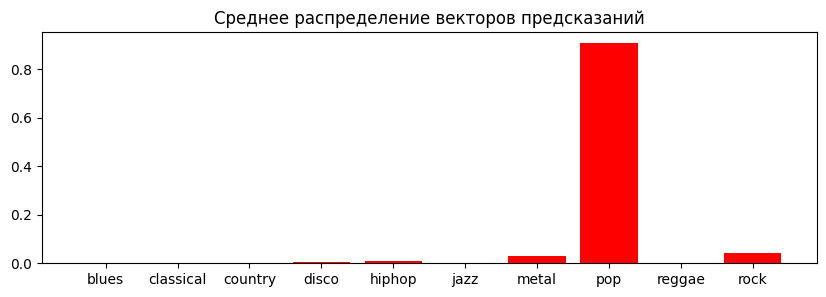

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 28ms/step
Классификация сети: pop - НЕВЕРНО.


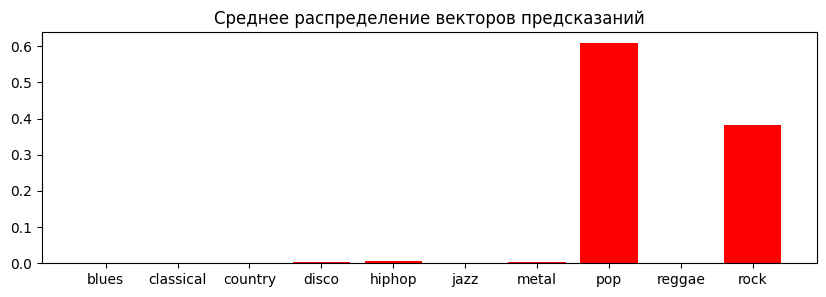

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: metal - НЕВЕРНО.


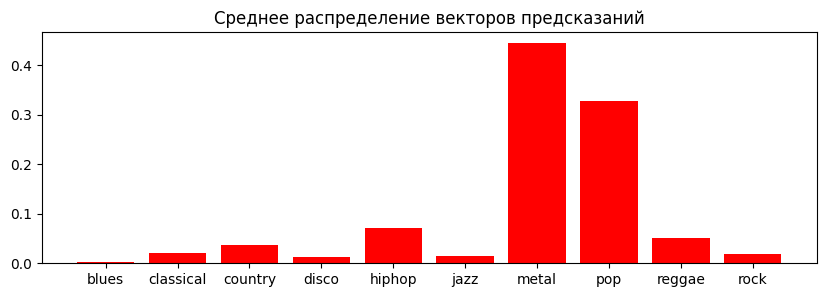

---------------------------------------------------------------
Файл: ./genres/jazz/jazz.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 39ms/step
Классификация сети: pop - НЕВЕРНО.


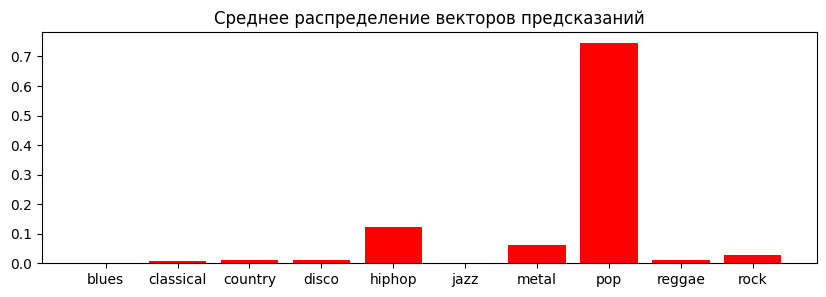

---------------------------------------------------------------
Файл: ./genres/metal/metal.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: country - НЕВЕРНО.


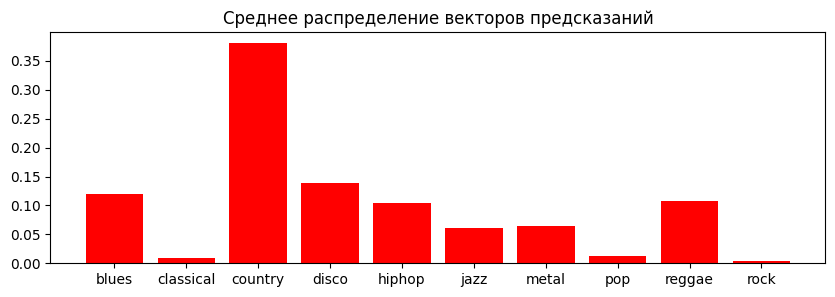

---------------------------------------------------------------
Файл: ./genres/metal/metal.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: blues - НЕВЕРНО.


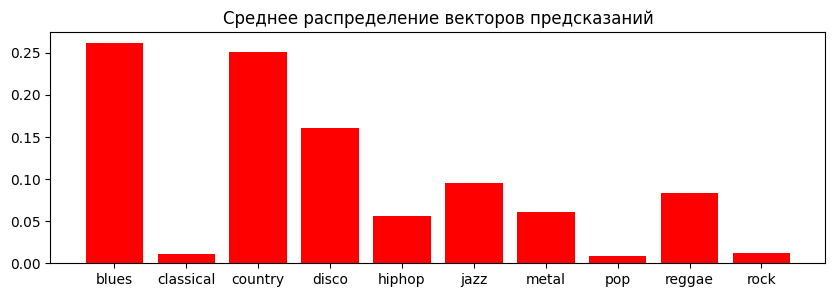

---------------------------------------------------------------
Файл: ./genres/metal/metal.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 28ms/step
Классификация сети: country - НЕВЕРНО.


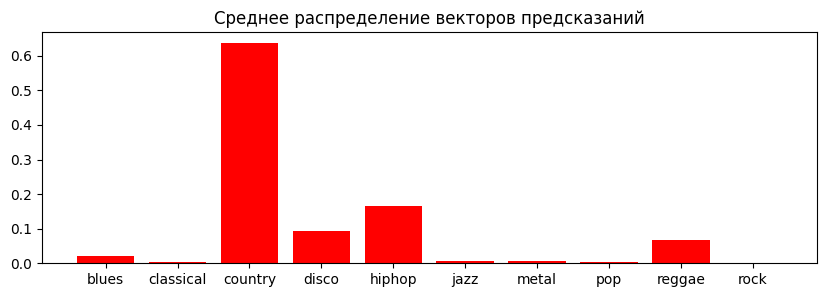

---------------------------------------------------------------
Файл: ./genres/metal/metal.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: blues - НЕВЕРНО.


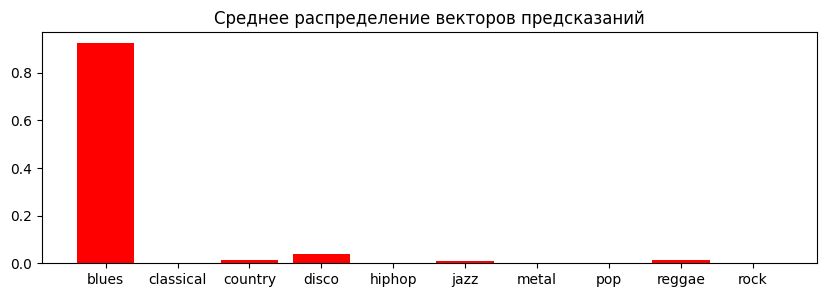

---------------------------------------------------------------
Файл: ./genres/metal/metal.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 21ms/step
Классификация сети: blues - НЕВЕРНО.


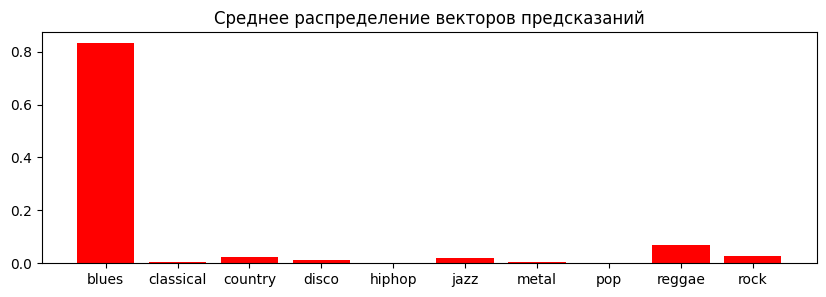

---------------------------------------------------------------
Файл: ./genres/metal/metal.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 31ms/step
Классификация сети: blues - НЕВЕРНО.


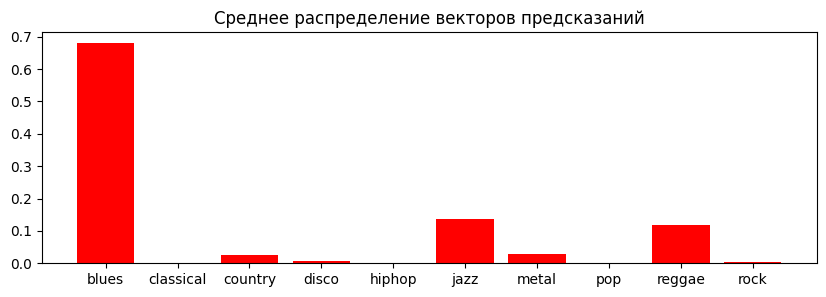

---------------------------------------------------------------
Файл: ./genres/metal/metal.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: blues - НЕВЕРНО.


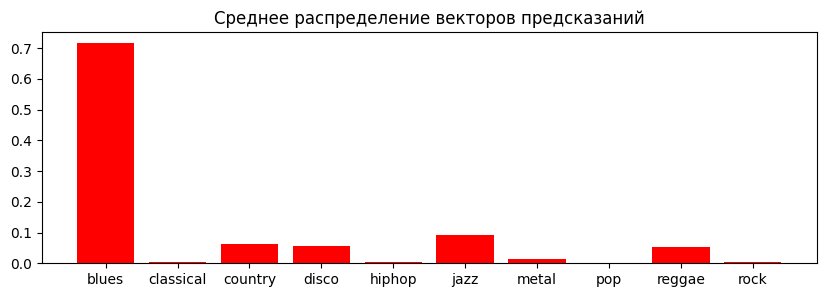

---------------------------------------------------------------
Файл: ./genres/metal/metal.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 35ms/step
Классификация сети: country - НЕВЕРНО.


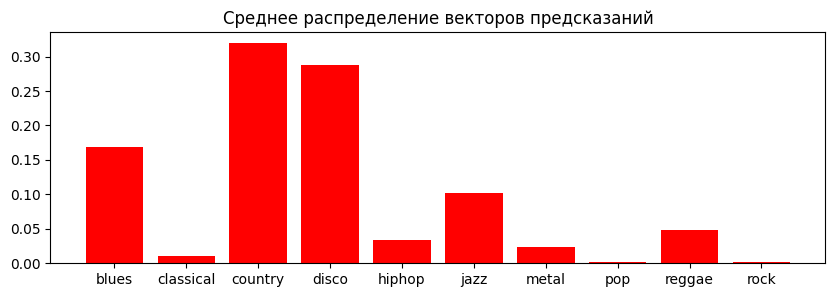

---------------------------------------------------------------
Файл: ./genres/metal/metal.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: blues - НЕВЕРНО.


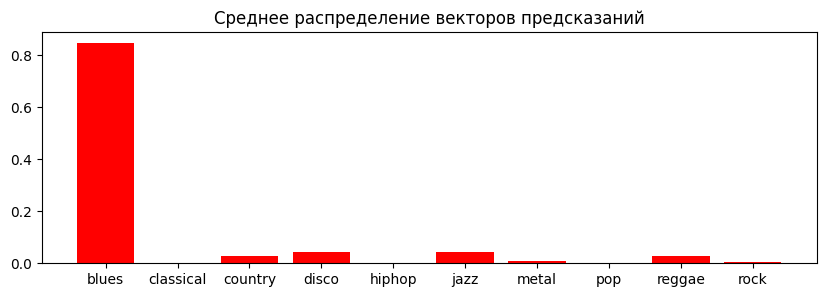

---------------------------------------------------------------
Файл: ./genres/metal/metal.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: blues - НЕВЕРНО.


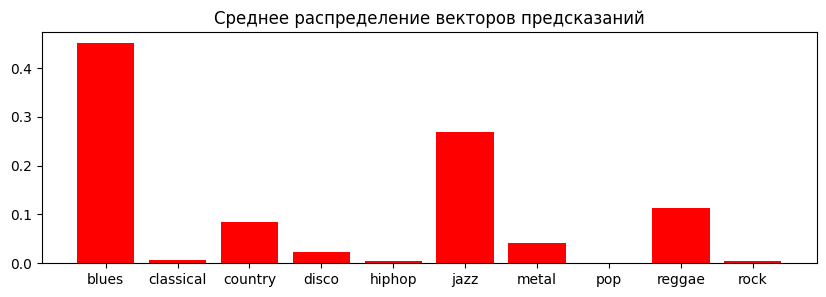

---------------------------------------------------------------
Файл: ./genres/pop/pop.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 43ms/step
Классификация сети: classical - НЕВЕРНО.


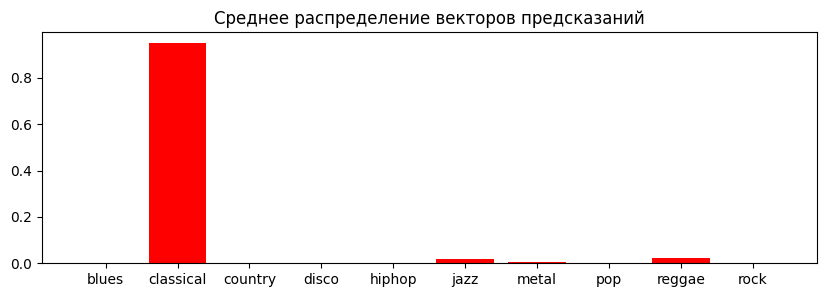

---------------------------------------------------------------
Файл: ./genres/pop/pop.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: classical - НЕВЕРНО.


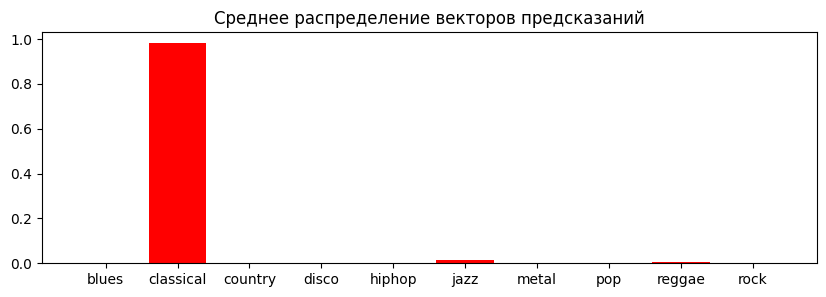

---------------------------------------------------------------
Файл: ./genres/pop/pop.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: classical - НЕВЕРНО.


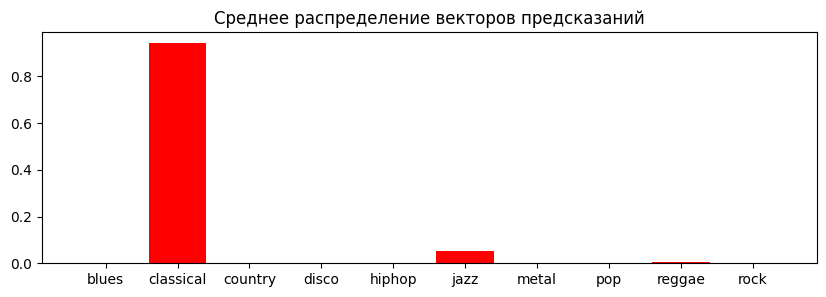

---------------------------------------------------------------
Файл: ./genres/pop/pop.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: classical - НЕВЕРНО.


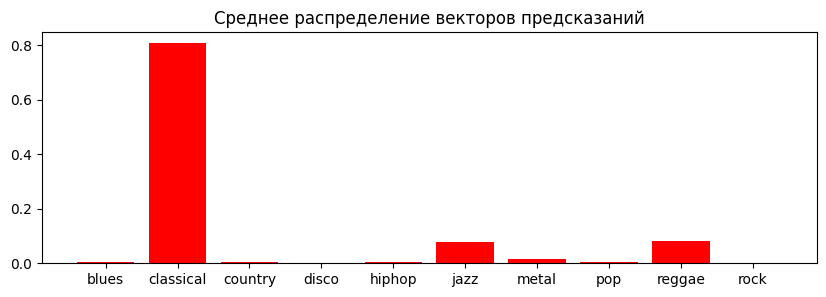

---------------------------------------------------------------
Файл: ./genres/pop/pop.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: classical - НЕВЕРНО.


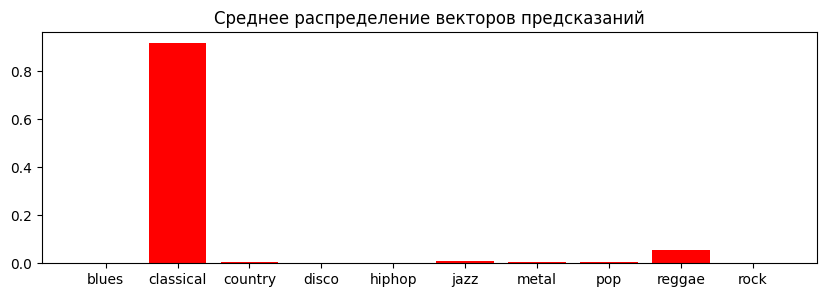

---------------------------------------------------------------
Файл: ./genres/pop/pop.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: classical - НЕВЕРНО.


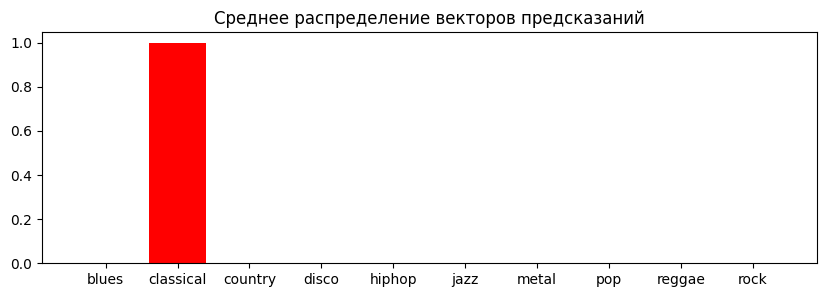

---------------------------------------------------------------
Файл: ./genres/pop/pop.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: classical - НЕВЕРНО.


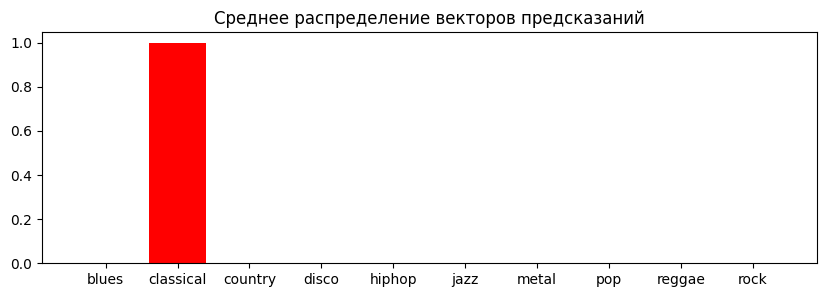

---------------------------------------------------------------
Файл: ./genres/pop/pop.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: classical - НЕВЕРНО.


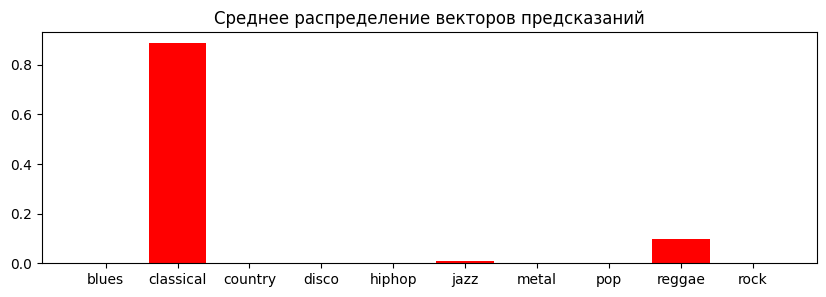

---------------------------------------------------------------
Файл: ./genres/pop/pop.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: classical - НЕВЕРНО.


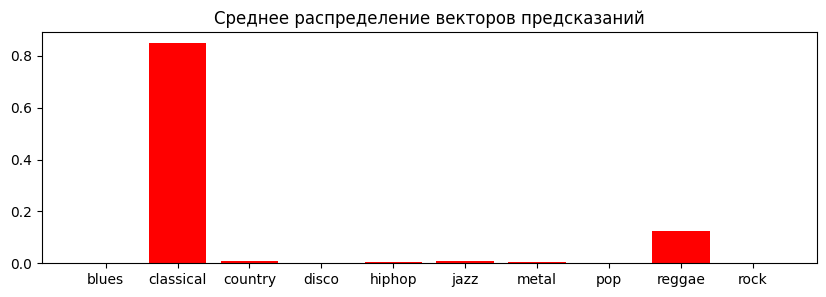

---------------------------------------------------------------
Файл: ./genres/pop/pop.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: classical - НЕВЕРНО.


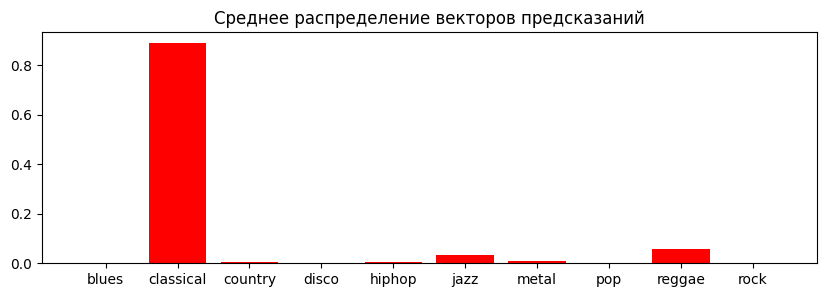

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: metal - НЕВЕРНО.


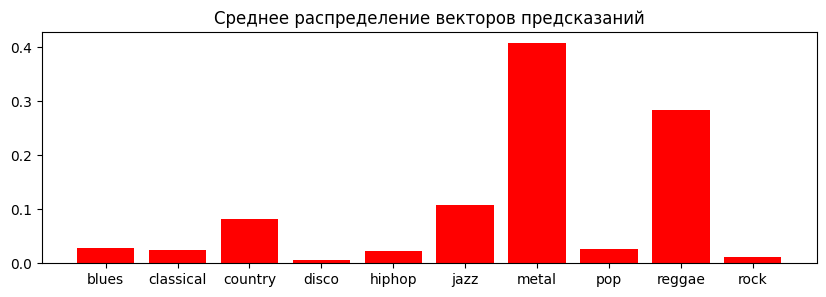

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 35ms/step
Классификация сети: metal - НЕВЕРНО.


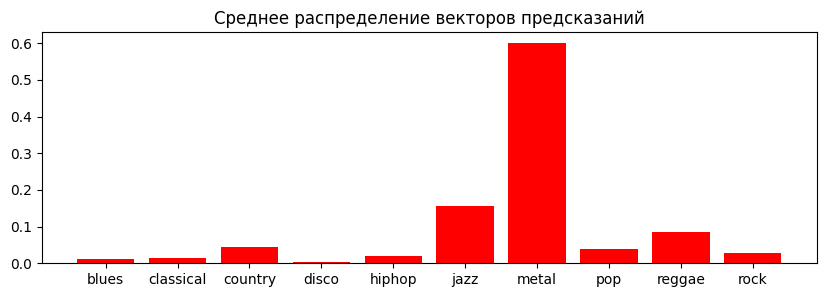

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: metal - НЕВЕРНО.


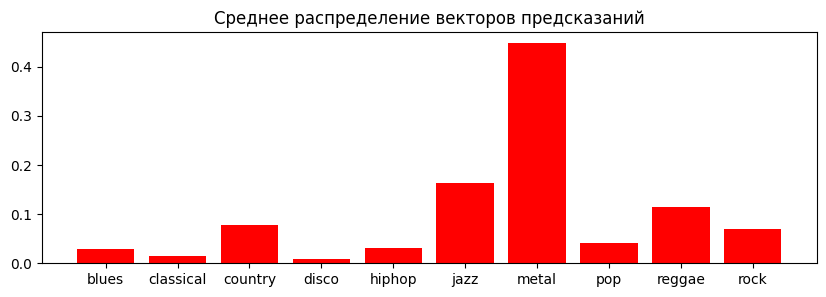

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: hiphop - НЕВЕРНО.


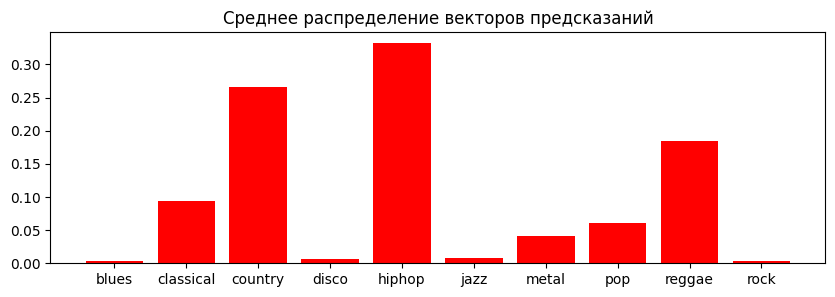

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 28ms/step
Классификация сети: classical - НЕВЕРНО.


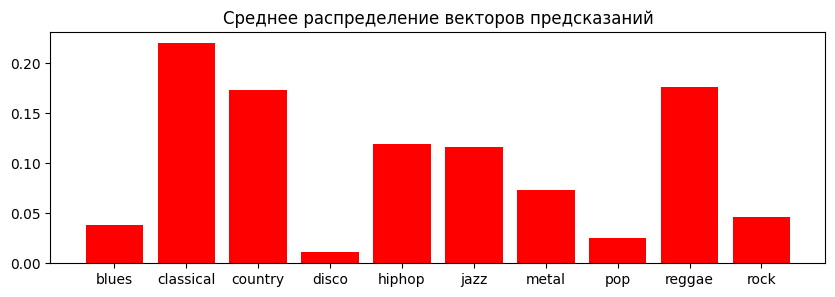

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: jazz - НЕВЕРНО.


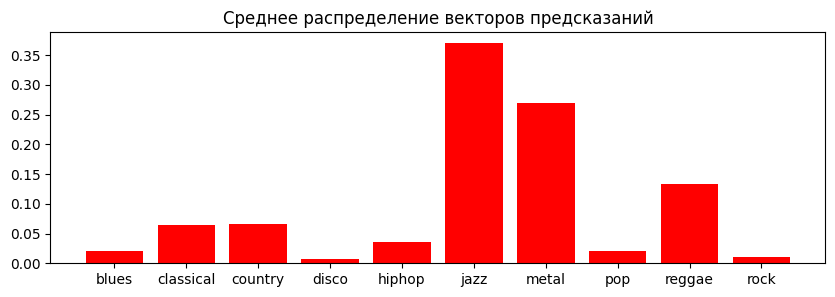

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 36ms/step
Классификация сети: metal - НЕВЕРНО.


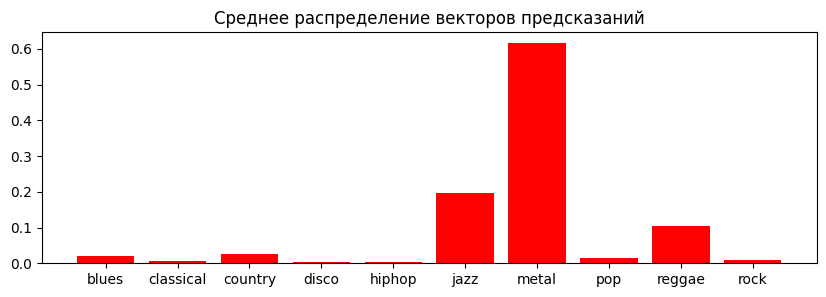

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: hiphop - НЕВЕРНО.


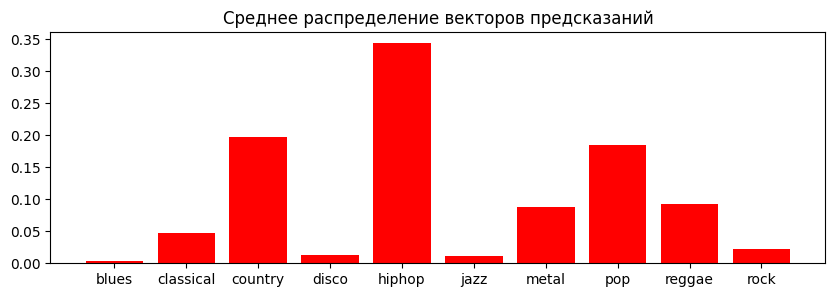

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: metal - НЕВЕРНО.


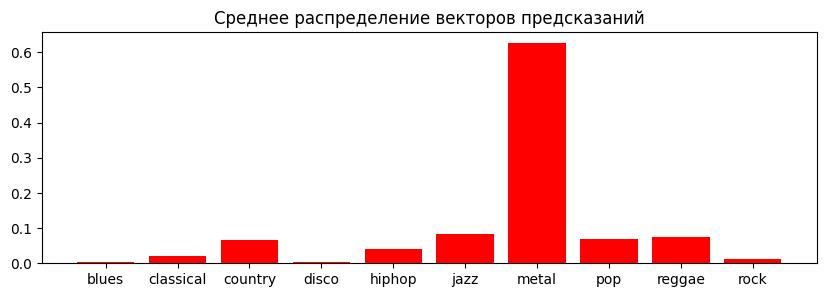

---------------------------------------------------------------
Файл: ./genres/reggae/reggae.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 24ms/step
Классификация сети: country - НЕВЕРНО.


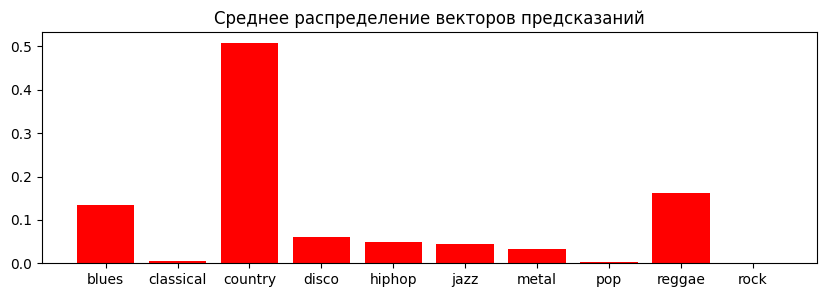

---------------------------------------------------------------
Файл: ./genres/rock/rock.00090.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 26ms/step
Классификация сети: disco - НЕВЕРНО.


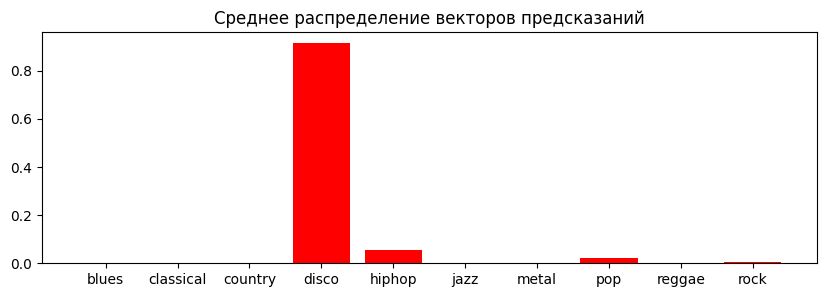

---------------------------------------------------------------
Файл: ./genres/rock/rock.00091.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 33ms/step
Классификация сети: reggae - НЕВЕРНО.


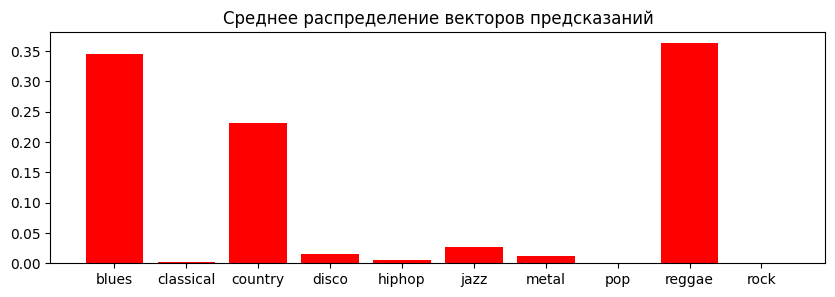

---------------------------------------------------------------
Файл: ./genres/rock/rock.00092.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: blues - НЕВЕРНО.


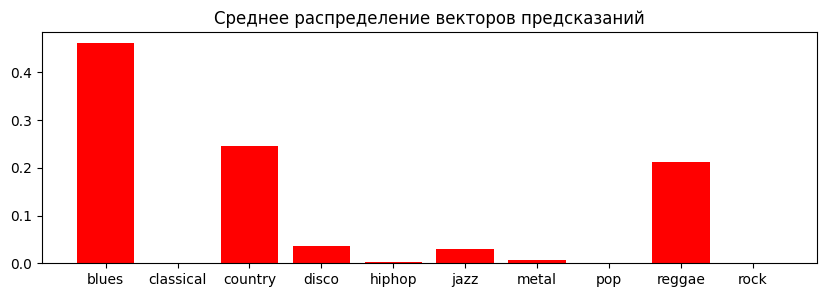

---------------------------------------------------------------
Файл: ./genres/rock/rock.00093.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 23ms/step
Классификация сети: blues - НЕВЕРНО.


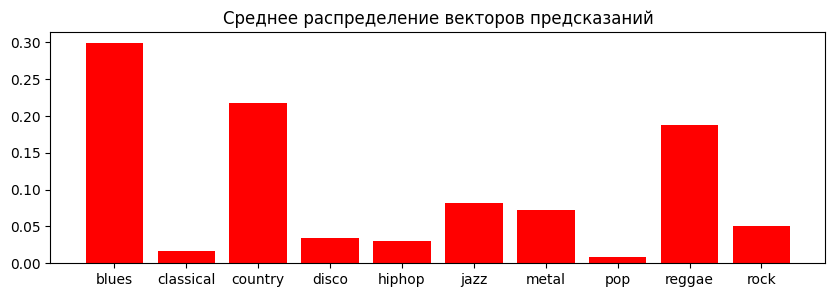

---------------------------------------------------------------
Файл: ./genres/rock/rock.00094.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: blues - НЕВЕРНО.


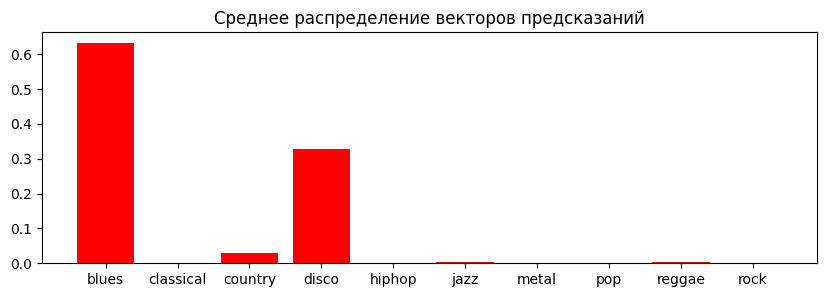

---------------------------------------------------------------
Файл: ./genres/rock/rock.00095.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: hiphop - НЕВЕРНО.


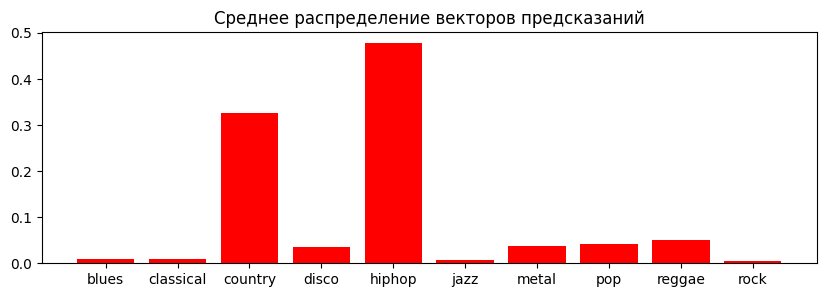

---------------------------------------------------------------
Файл: ./genres/rock/rock.00096.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 22ms/step
Классификация сети: country - НЕВЕРНО.


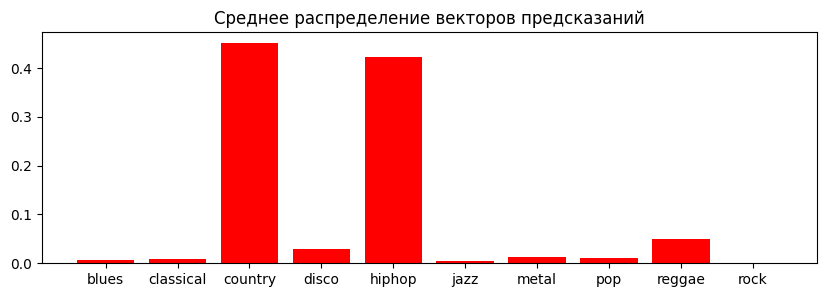

---------------------------------------------------------------
Файл: ./genres/rock/rock.00097.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 27ms/step
Классификация сети: blues - НЕВЕРНО.


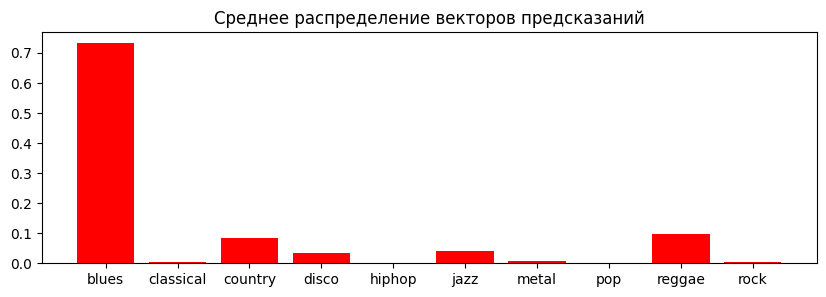

---------------------------------------------------------------
Файл: ./genres/rock/rock.00098.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: hiphop - НЕВЕРНО.


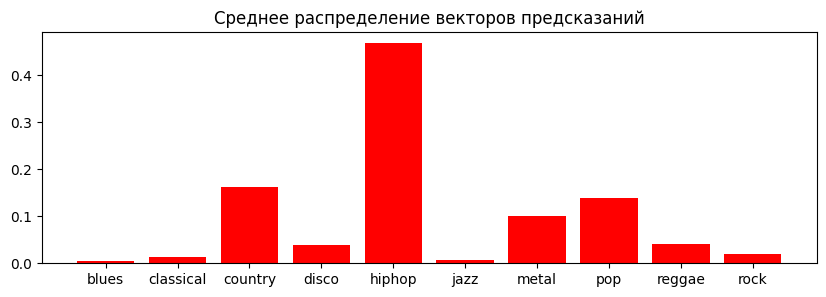

---------------------------------------------------------------
Файл: ./genres/rock/rock.00099.au
Векторы для предсказания: (1, 37)
1/1 [==============================] - 0s 25ms/step
Классификация сети: disco - НЕВЕРНО.


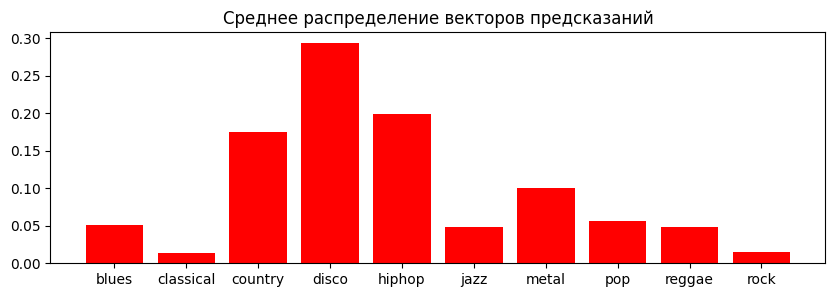

---------------------------------------------------------------
=== Обработано образцов: 100, из них распознано верно: 2, доля верных: 2.0% ===


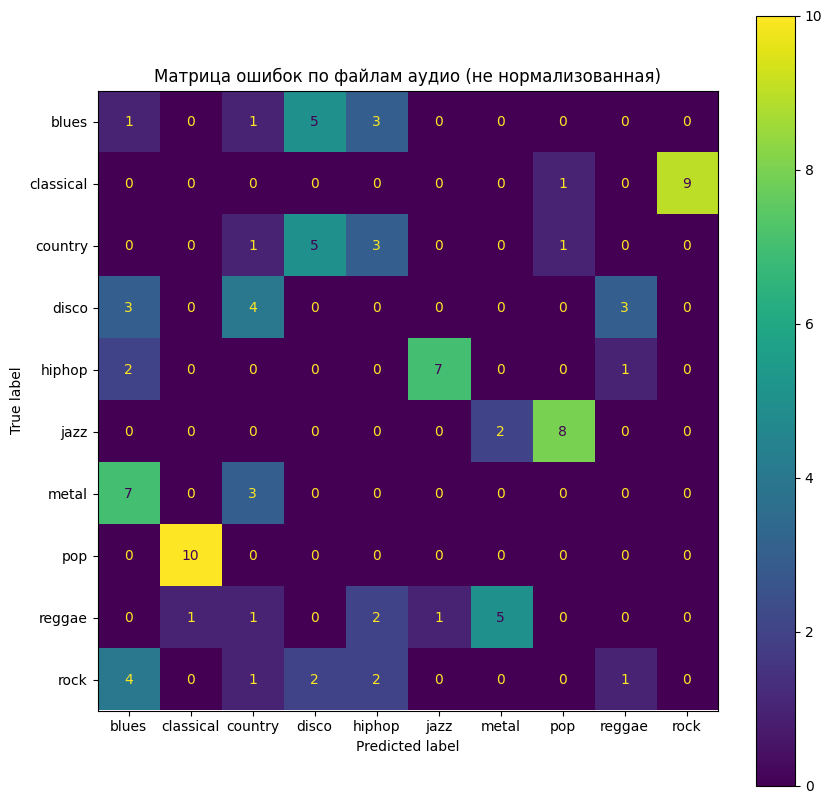

In [21]:
# Ваше решение
classify_test_files(model, x_scaler, 90, 10)